Making some graphs to use in presentations

Updated 3/8/2024

In [2]:
from g4beam import *
from scan import *

import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
import numpy as np
import pandas as pd
from tqdm import *
import pickle
import itertools
from tabulate import tabulate
import json
import lzma

In [3]:
# Load results
with lzma.open("results/first_wedge_length_angle.pkl.lzma", "rb") as file:
    results1 = pickle.load(file)

with lzma.open("results/second_wedge_length_angle.pkl.lzma", "rb") as file:
    results2 = pickle.load(file)

# First wedge optimization landscape

In [13]:
# Range used in the scan
angles = np.linspace(30, 60, 20)
lengths = np.linspace(5, 11, 20)

# Calculate values to graph
mesh = np.meshgrid(lengths, angles)
meshz = qmap_to_meshgrid(mesh, calc_quantity(lambda df: emittances(cut_outliers(df))[0], results1))
meshx, meshy = mesh

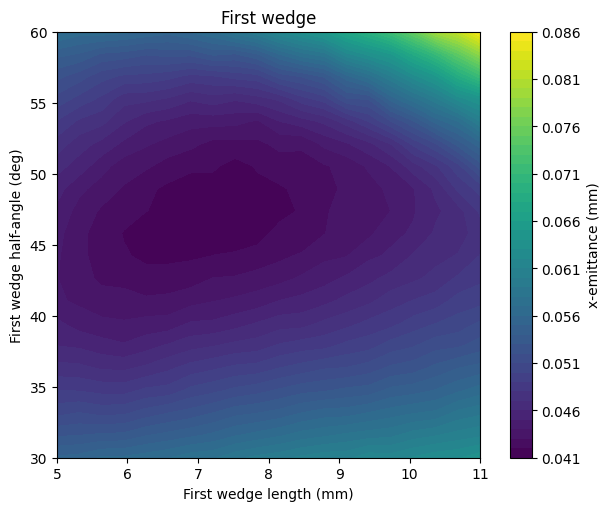

In [14]:
fig, ax1 = plt.subplots(layout="constrained")
fig.set_size_inches(6, 5)

cax = ax1.contourf(meshx, meshy, meshz, levels=50)
ax1.set_xlabel("First wedge length (mm)")
ax1.set_ylabel("First wedge half-angle (deg)")
ax1.set_title("First wedge")
plt.colorbar(cax, ax=ax1).set_label("x-emittance (mm)")

This will generate a graph of both first and second if you want that

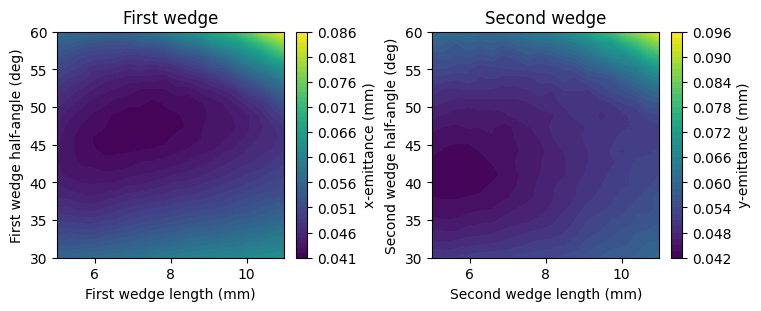

In [9]:
# Range used in the scan
angles = np.linspace(30, 60, 20)
lengths = np.linspace(5, 11, 20)

fig, (ax1, ax2) = plt.subplots(ncols=2, layout="constrained")
fig.set_size_inches(10*0.75, 4*0.75)

# Graph the first wedge
mesh = np.meshgrid(lengths, angles)
meshz = qmap_to_meshgrid(mesh, calc_quantity(lambda df: emittances(cut_outliers(df))[0], results1))
meshx, meshy = mesh

cax = ax1.contourf(meshx, meshy, meshz, levels=50)
ax1.set_xlabel("First wedge length (mm)")
ax1.set_ylabel("First wedge half-angle (deg)")
ax1.set_title("First wedge")
plt.colorbar(cax, ax=ax1).set_label("x-emittance (mm)")

# Graph the second wedge
mesh = np.meshgrid(lengths, angles)
meshz = qmap_to_meshgrid(mesh, calc_quantity(lambda df: emittances(cut_outliers(df))[1], results2))
meshx, meshy = mesh

cax = ax2.contourf(meshx, meshy, meshz, levels=50)
ax2.set_xlabel("Second wedge length (mm)")
ax2.set_ylabel("Second wedge half-angle (deg)")
ax2.set_title("Second wedge")
plt.colorbar(cax, ax=ax2).set_label("y-emittance (mm)")

# Phase space evolution

In [4]:
# Load parameter set
filename = "results/parameters/"+input("Enter run name to load: ")+".json"
with open(filename, "r") as file:
    parameters = json.load(file)
    globals().update(parameters)
    print("Loaded from", filename)

Enter run name to load:  145_new


Loaded from results/parameters/145_new.json


In [5]:
start = time.time()
# Run best case
pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=200000)
print("Running first wedge")
%time post_w1 = run_distribution(pre_w1, w1_length, w1_angle, vd_dist, axis=0)
print("Results of first wedge")
print_all_params(post_w1)
post_correct = remove_dispersion(post_w1)
reverse_transverse = post_correct.copy(deep=True)
reverse_transverse["Px"] *= -1
reverse_transverse["Py"] *= -1
drift_to_start = drift_length-rf_length/2
post_drift = recenter_t(z_prop(post_correct, drift_to_start))
no_transverse = remove_transverse(post_drift)
print("Running RF cavity")
%time post_cavity = cut_pz(recenter_t(run_g4beam(no_transverse, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad, nparticles=len(no_transverse))), tails=0.15)
pre_w2 = recombine_transverse(post_cavity, reverse_transverse)
print("Running second wedge")
%time post_w2 = run_distribution(pre_w2, w2_length, w2_angle, vd_dist, axis=1)
post_w2_cut = recenter_t(cut_outliers(post_w2))
post_w2_correct = remove_dispersion(post_w2_cut)
print_all_params(post_w2_correct)
beep()
print(f"Time elapsed: {time.time() - start:.1f}")

Running first wedge
CPU times: total: 1.64 s
Wall time: 35.2 s
Results of first wedge
-----------------------------
Twiss parameters for X
emit  = 0.04607763721168657 mm
beta  = 0.03505771780718582 m
gamma = 191.23510346555256 1/m
alpha = -2.388360586704471
D     = 0.02000205967503614 m
D'    = -0.045385153585430195

Twiss parameters for Y
emit  = 0.1512396439596464 mm
beta  = 0.025395456723704808 m
gamma = 58.12905092416061 1/m
alpha = -0.6900824567648085
D     = -3.040094169777366e-05 m
D'    = -0.0006836364243560088

Z-emittance:  6.333959989667358 mm
Z std: 142.33499884474082 mm
p std: 7.173253046606102 MeV/c
Mean momentum: 87.26515197426903 MeV/c
-----------------------------
Running RF cavity
CPU times: total: 2.08 s
Wall time: 6min 1s
Running second wedge
CPU times: total: 2.36 s
Wall time: 24.3 s
-----------------------------
Twiss parameters for X
emit  = 0.0400833911364926 mm
beta  = 0.04847200732950831 m
gamma = 242.46201620176012 1/m
alpha = -3.2791188795862642
D     = -1.2

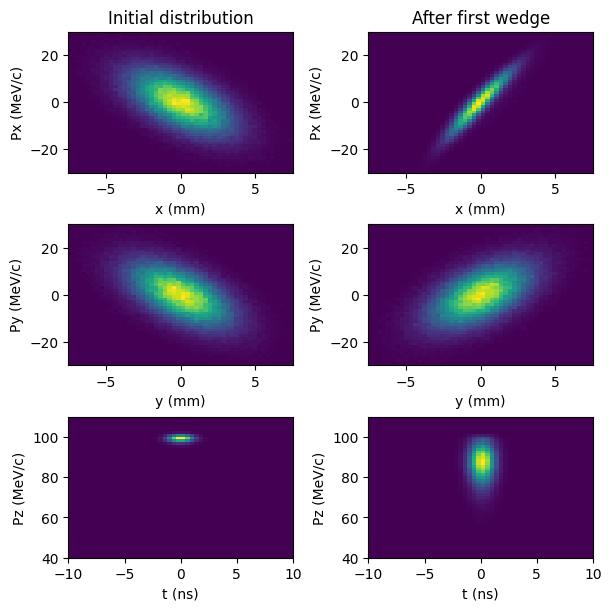

In [13]:
# Make some phase space plots
PLOT_TARGETS = [pre_w1, post_correct]
PLOT_TITLES = ["Initial distribution", "After first wedge"]
PLOT_AXES = [("x", "Px"), ("y", "Py"), ("t", "Pz")]
PLOT_LABELS = [("x (mm)", "Px (MeV/c)"), ("y (mm)", "Py (MeV/c)"), ("t (ns)", "Pz (MeV/c)")]
T_RANGES = [[-7.5, 7.5], [-30, 30]]
L_RANGES = [[-10, 10], [40, 110]]

fig, axes = plt.subplots(nrows = len(PLOT_AXES), ncols = len(PLOT_TARGETS), layout="constrained")
fig.set_size_inches(6, 6)
for i, df in enumerate(PLOT_TARGETS):
    axes[0][i].set_title(PLOT_TITLES[i])
    for j, ((xaxis, yaxis), (xlabel, ylabel)) in enumerate(zip(PLOT_AXES, PLOT_LABELS)):
        ax = axes[j][i]
        ax.hist2d(df[xaxis], df[yaxis], bins=50, range=L_RANGES if j == 2 else T_RANGES)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
# fig.suptitle(f"temit={t_emit*1000:.0f} μm, σP={pz_std:.2f} MeV/c")
plt.savefig("visuals/phase space compact half.png")

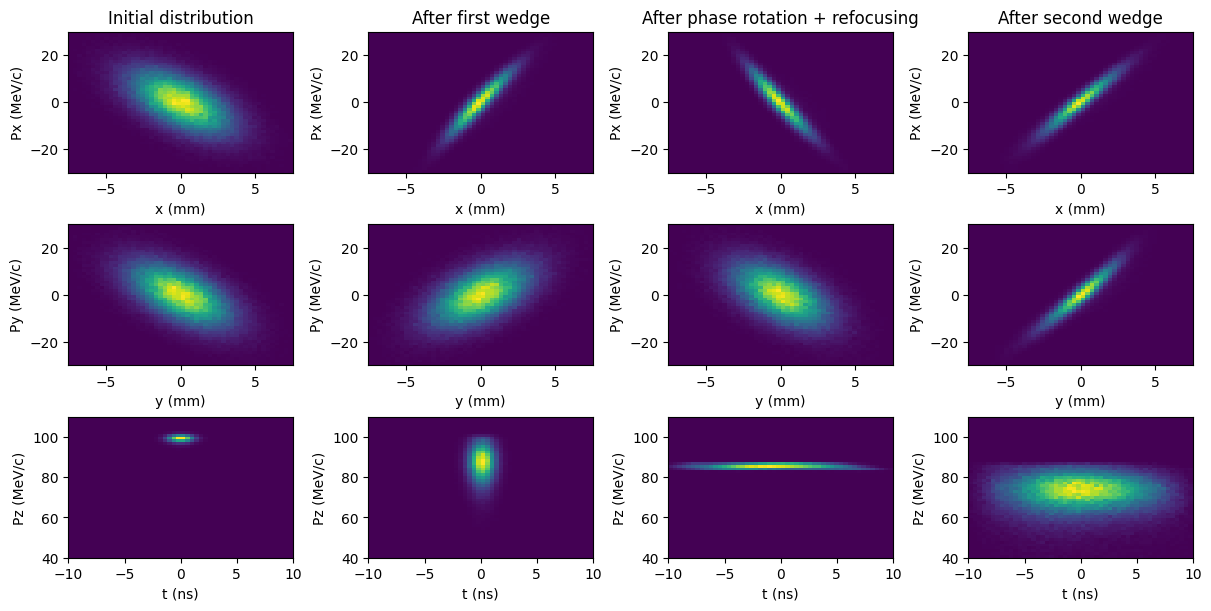

In [6]:
# Make some phase space plots
PLOT_TARGETS = [pre_w1, post_correct, pre_w2, post_w2_correct]
PLOT_TITLES = ["Initial distribution", "After first wedge", "After phase rotation + refocusing", "After second wedge"]
PLOT_AXES = [("x", "Px"), ("y", "Py"), ("t", "Pz")]
PLOT_LABELS = [("x (mm)", "Px (MeV/c)"), ("y (mm)", "Py (MeV/c)"), ("t (ns)", "Pz (MeV/c)")]
T_RANGES = [[-7.5, 7.5], [-30, 30]]
L_RANGES = [[-10, 10], [40, 110]]

fig, axes = plt.subplots(nrows = len(PLOT_AXES), ncols = len(PLOT_TARGETS), layout="constrained")
fig.set_size_inches(12, 6)
for i, df in enumerate(PLOT_TARGETS):
    axes[0][i].set_title(PLOT_TITLES[i])
    for j, ((xaxis, yaxis), (xlabel, ylabel)) in enumerate(zip(PLOT_AXES, PLOT_LABELS)):
        ax = axes[j][i]
        ax.hist2d(df[xaxis], df[yaxis], bins=50, range=L_RANGES if j == 2 else T_RANGES)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
# fig.suptitle(f"temit={t_emit*1000:.0f} μm, σP={pz_std:.2f} MeV/c")
plt.savefig("visuals/phase space compact.png")

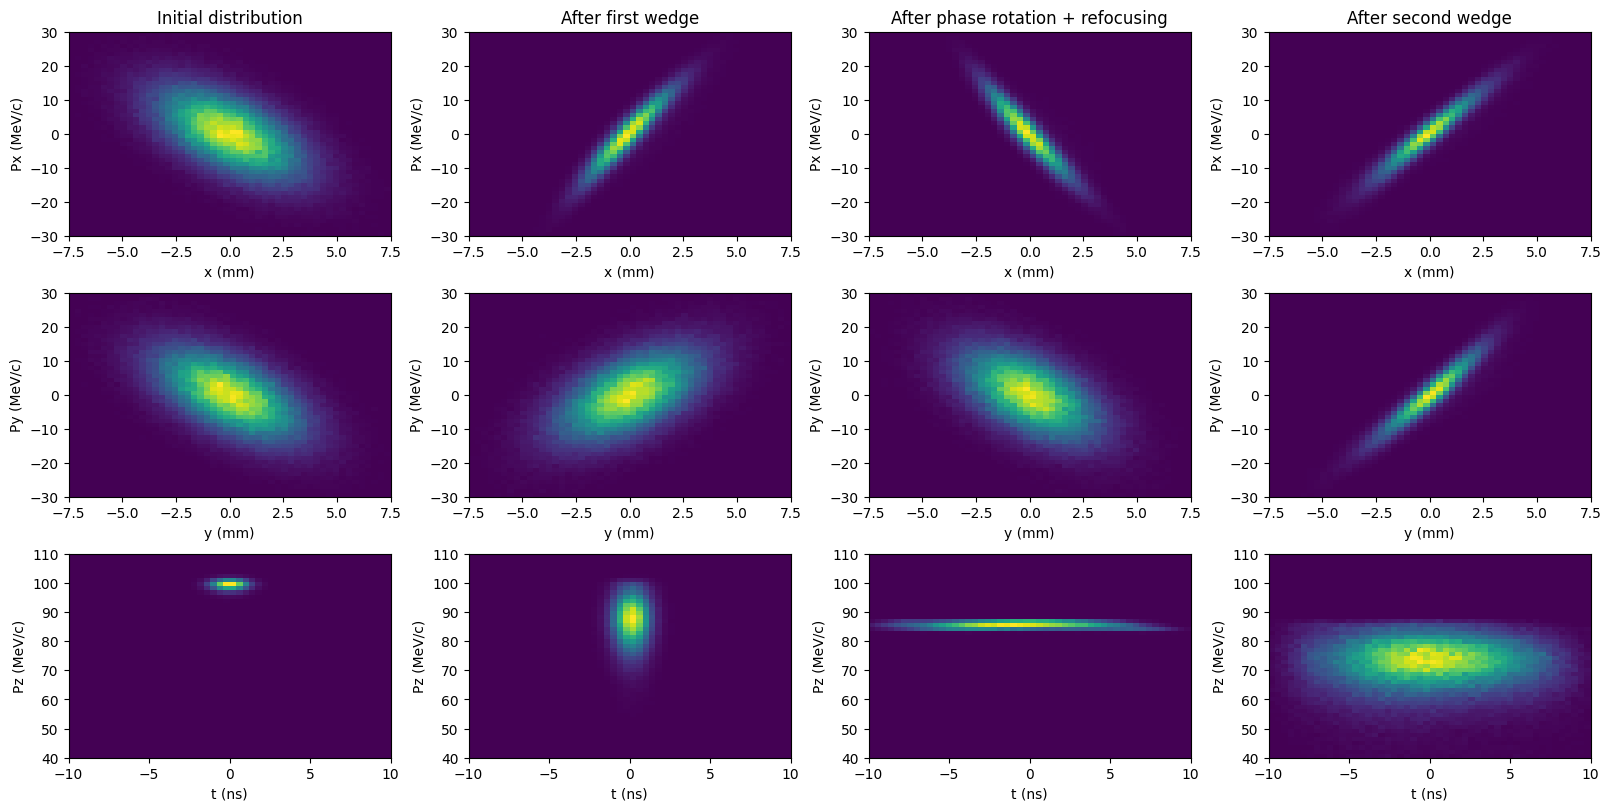

In [7]:
# Make some phase space plots
PLOT_TARGETS = [pre_w1, post_correct, pre_w2, post_w2_correct]
PLOT_TITLES = ["Initial distribution", "After first wedge", "After phase rotation + refocusing", "After second wedge"]
PLOT_AXES = [("x", "Px"), ("y", "Py"), ("t", "Pz")]
PLOT_LABELS = [("x (mm)", "Px (MeV/c)"), ("y (mm)", "Py (MeV/c)"), ("t (ns)", "Pz (MeV/c)")]
T_RANGES = [[-7.5, 7.5], [-30, 30]]
L_RANGES = [[-10, 10], [40, 110]]

fig, axes = plt.subplots(nrows = len(PLOT_AXES), ncols = len(PLOT_TARGETS), layout="constrained")
fig.set_size_inches(16, 8)
for i, df in enumerate(PLOT_TARGETS):
    axes[0][i].set_title(PLOT_TITLES[i])
    for j, ((xaxis, yaxis), (xlabel, ylabel)) in enumerate(zip(PLOT_AXES, PLOT_LABELS)):
        ax = axes[j][i]
        ax.hist2d(df[xaxis], df[yaxis], bins=50, range=L_RANGES if j == 2 else T_RANGES)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
# fig.suptitle(f"temit={t_emit*1000:.0f} μm, σP={pz_std:.2f} MeV/c")

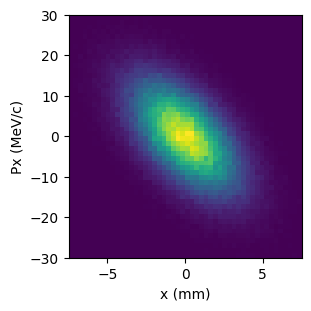

In [26]:
fig, ax = plt.subplots(layout="constrained")
fig.set_size_inches((3, 3))
ax.hist2d(pre_w1["x"], pre_w1["Px"], bins=50, range=T_RANGES)
ax.set_xlabel("x (mm)")
ax.set_ylabel("Px (MeV/c)")
# ax.set_title("Example phase-space plot")
plt.savefig(f"output/sample.png")

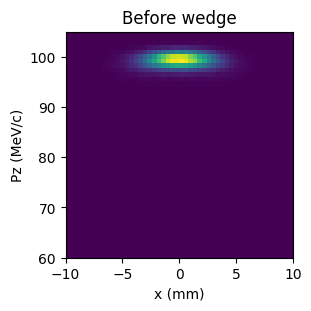

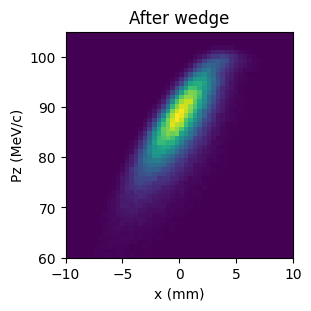

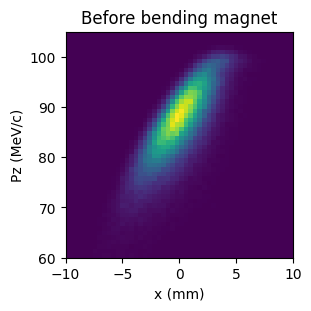

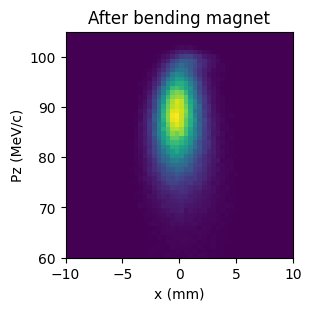

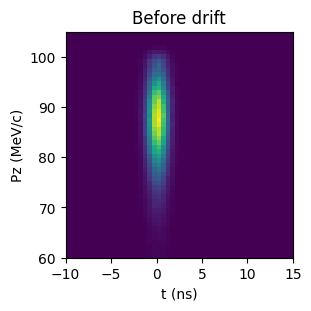

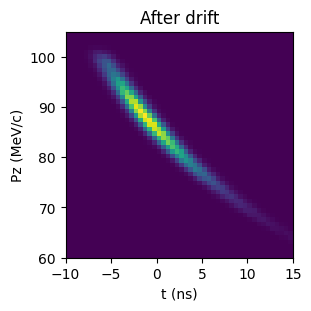

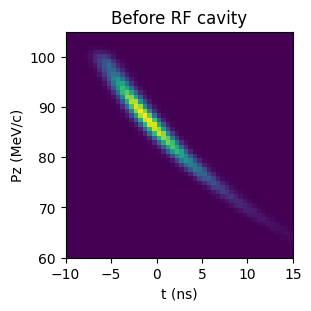

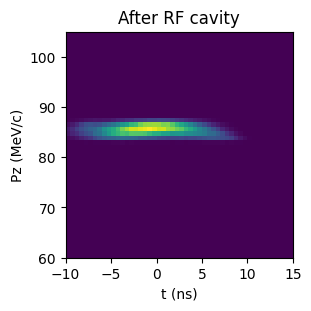

In [16]:
dfs = [pre_w1, post_w1]
bounds = [[-10, 10], [60, 105]]
x_axis = "x"
y_axis = "Pz"
x_label = "x (mm)"
y_label = "Pz (MeV/c)"
titles = ["Before wedge", "After wedge"]

n = 0
def compare_graphs(dfs, titles, x_axis, y_axis, x_label, y_label, bounds):
    global n
    n += 1
    for i, (df, title) in enumerate(zip(dfs, titles)):
        fig, ax = plt.subplots(layout="constrained")
        fig.set_size_inches((3, 3))
        ax.hist2d(df[x_axis], df[y_axis], bins=50, range=bounds)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(title)
        plt.savefig(f"output/{n}_{i}.png")

compare_graphs([pre_w1, post_w1], ["Before wedge", "After wedge"], "x", "Pz", "x (mm)", "Pz (MeV/c)", [[-10, 10], [60, 105]])
compare_graphs([post_w1, post_correct], ["Before bending magnet", "After bending magnet"], "x", "Pz", "x (mm)", "Pz (MeV/c)", [[-10, 10], [60, 105]])
compare_graphs([post_correct, post_drift], ["Before drift", "After drift"], "t", "Pz", "t (ns)", "Pz (MeV/c)", [[-10, 15], [60, 105]])
compare_graphs([post_drift, post_cavity], ["Before RF cavity", "After RF cavity"], "t", "Pz", "t (ns)", "Pz (MeV/c)", [[-10, 15], [60, 105]])
# compare_graphs([pre_w1, post_correct], ["Before first wedge", "After first wedge"], "x", "Px", "x (mm)", "Px (MeV/c)", [[-10, 10], [-30, 30]])
# compare_graphs([pre_w2, post_w2_correct], ["Before second wedge", "After second wedge"], "y", "Py", "y (mm)", "Py (MeV/c)", [[-10, 10], [-30, 30]])